# CS188 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [42]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import *
from sklearn.preprocessing import *
import scipy.stats
from sklearn.base import BaseEstimator, TransformerMixin

from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [4]:
# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True

    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))

    roc_auc = auc(fpr, tpr)

    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))

    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )

    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)

    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')

    ax.legend(loc="lower right")
    return ax

## Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [5]:
DATA_PATH = 'heartdisease.csv'
df = pd.read_csv(DATA_PATH)
df.shape

(303, 14)

### Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method,  the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [6]:
df.head()
df.describe()
df.info()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  sick      303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


### Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

# Response

While all of the features are numeric type, many of them are categorical in nature and do not necessarily have an order, so these features might need to be encoded using `OneHotEncoder`. The target column takes on a boolean value so we will want to convert that from True/False to 1/0.

---

### Determine if we're dealing with any null values. If so, report on which columns? 

In [7]:
print(f'Data contains null: {df.isnull().sum().any()} -- Data contains NaN: {df.isna().sum().any()}')

Data contains null: False -- Data contains NaN: False


# Response

No, none of the columns contain Null or NaN values.

---

### Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe. (hint: try label encoder or .astype()

In [8]:
df.sick = LabelEncoder().fit_transform(df.sick)

### Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? 

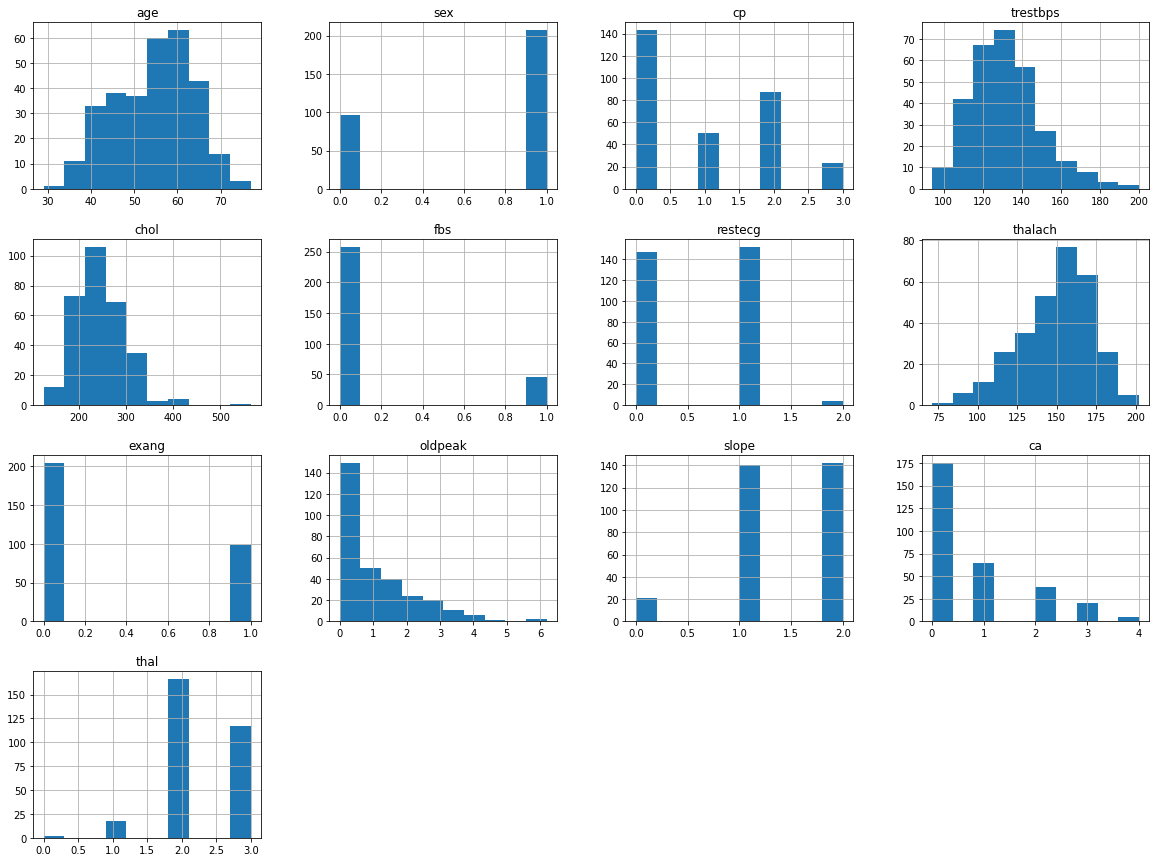

In [9]:
_ = df.drop(columns=['sick']).hist(figsize=(20, 15))
plt.show()

# Response

- Age: The age feature appears follows what appears to be a bi-modal distribution.
- Sex: There appears that there are twice as many male respondents as there are female respondents.
- CP: There is a limited selection of values, with asymptomatic (0) being the largest and non-anginal (2) being the second largest. Typical and atypical anginal pain represents a relatively small portion of the sample.
- TrestBPS: This appears to follow a somewhat normal distribution, although skewed slightly to the right, depending on how many bins we allocate to our histogram.
- Chol: This also follows a normal distribution.
- FBS: This binary feature is disproportionately equal to 0, implying most of the respondents did not have a fasting blood sugar higher than 120 mg/dl
- RestECG: This limited selection feature takes on three distinct values. Roughly half of all respondents are considered normal (1), another half show probably or definite left ventricular hypertrophy by Estes' criteria, and a very small amount of respondents have ST-T wave abnormality.
- Thalach: Here we have another roughly-normal distribution skewed somewhat to the left. Most people fall within the range of roughly 110-180 BPS.
- Exang: In this boolean feature, about 2/3 of respondents do not show signs of exercise induced angina and the other 1/3 of respondents do show signs.
- OldPeakST: This feature follows an decreasing exponential distribution. A majority of respondents have values of about 1.20 or less.
- Slope: This limited selection feature shows that about half of respondents have upward or flat sloping ST segments
- CA: This limited selection feature appears to follow a decreasing exponenetial distribution.
- Thal: This feature is limited selection, with most of the respondents having values of 2 (fixed defect) or 3 (reversible defect)

### We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

Number of healthy patients: 165
Number of sick patients: 138


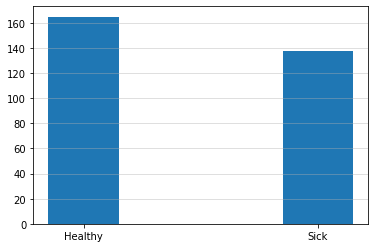

In [10]:
n_healthy = df.sick[df.sick == False].count()
n_sick = df.sick[df.sick == True].count()
print(f'Number of healthy patients: {n_healthy}')
print(f'Number of sick patients: {n_sick}')
_ = plt.bar([0, 1], [n_healthy, n_sick], tick_label=['Healthy', 'Sick'], width=0.3)
plt.grid(which='major', axis='y', alpha=0.5)

# Response

There are 165 healthy patients and 138 sick patients. This means that roughly 45% of the samples come from sick patients, which leads me to conclude that the data set is in fact equitably distributed.

---

### Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

# Response

Artifically balancing a data set can lead to overfitting and loss of information and/or generality. An artificially balanced data set will necessarily have a reduced sample count in order to compensate for missing targets. A dramatic reduction is samples will inherently result in loss of information, some of which may be necessary to build a proper model. Further, it might be the case that the more rare target is, in fact, less frequent in a real world setting. So by artificially balancing a dataset, we are making that target look more common than it really is, which could lead to overfitting.

---

### Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

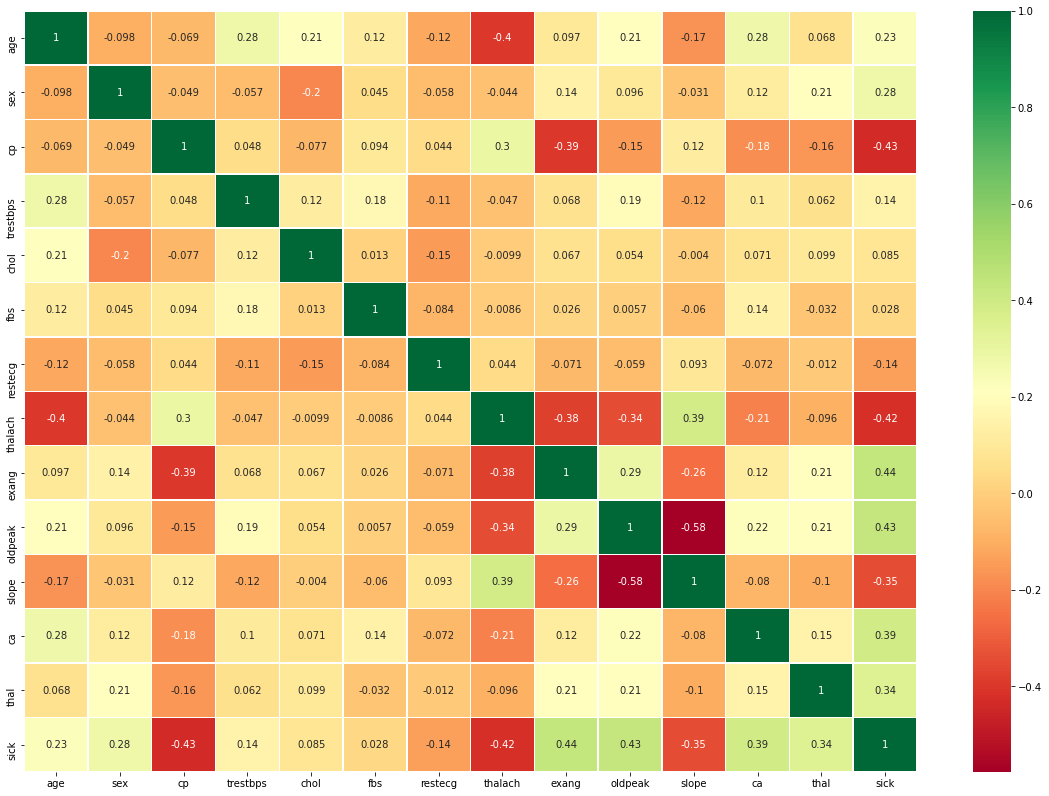

In [11]:
fig, ax = plt.subplots(figsize=(20,14))
_ = sns.heatmap(df.corr(), annot=True, linewidths=0.5, ax=ax, cmap='RdYlGn')

In [12]:
sick_corr = df[df.columns[:]].corr()['sick'][:]
sick_corr[:-1]

age         0.225439
sex         0.280937
cp         -0.433798
trestbps    0.144931
chol        0.085239
fbs         0.028046
restecg    -0.137230
thalach    -0.421741
exang       0.436757
oldpeak     0.430696
slope      -0.345877
ca          0.391724
thal        0.344029
Name: sick, dtype: float64

# Response

Some of the more highly correlated features include chest pain (cp), maximum heart rate (thalach), exercise induced angina (exang), and depression induced by exercise (oldpeakST).

Chest pain is one of the biggest signs of heart disease, and the pressence of typical or atypical anginal chest pain signifies high to moderate risk of heart disease. Exercise induced angina is a sign of "stable" angina, which occurs when your heart demands more blood, but narrowed arteries slow down blood flow. Maximum heart rate is significant because a lower maximum is more conducive to heart related issues, which may be contributory to heart disease. Finally, ST segment depression induced by exercise is "the most reliable indicator of exercise-induced [myocardial] ischaemia," which occurs when the blood flow to your heart is reduced, preventing the heart muscle from receiving enough oxygen.

Given that all of these features relate to the heart and predict serious heart issues, it is not surprising that they have higher correlation to sickness than do other features.

---

## Part 2. Prepare the Data and run a KNN Model

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Save the label column as a separate array and then drop it from the dataframe. 

In [13]:
X = df.drop(columns='sick').copy()
y = df.sick.copy()

### First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 80% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [14]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, train_size=0.8, random_state=42)
X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape

((242, 13), (242,), (61, 13), (61,))

### In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN's rely on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [15]:
clf = KNeighborsClassifier()
_ = clf.fit(X_train_raw, y_train_raw)
pred = clf.predict(X_test_raw)
print('Accuracy on test data: ', clf.score(X_test_raw, y_test_raw))

Accuracy on test data:  0.6885245901639344


# Response

The accuracy of KNN with a default `k_neighbors=5` is **0.689%**.

---

### Now implement a pipeline of your choice. You can opt to handle categoricals however you wish, however please scale your numeric features using standard scaler

### Pipeline:

In [16]:
X = df.drop(columns='sick').copy()
y = df.sick.copy()

In [44]:
class InvalidValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print(f'X type: {type(X)} - X shape: {X.shape}')

#### Impute features with invalid values

In [17]:
X.thal[X.thal == 0] = scipy.stats.mode(X.thal)
X.ca[X.ca == 4] = 0

<ipython-input-17-6be803663e04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.thal[X.thal == 0] = scipy.stats.mode(X.thal)
<ipython-input-17-6be803663e04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.ca[X.ca == 4] = 0


According to [this link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1123032/):

- By convention, the maximum predicted heart rate is calculated as 220 (210 for women) minus the patient's age

- A satisfactory heart rate response is achieved on reaching 85% of the maximum predicted heart rate

- Attainment of maximum heart rate is a good prognostic sign

In [18]:
max_pred_hr = [0] * len(df)
for i in range(len(df)):
    if X.iloc[i].sex == 1:
        max_pred_hr[i] = 220 - X.iloc[i].age
    else:
        max_pred_hr[i] = 210 - X.iloc[i].age

X['satisfactory_hr'] = LabelEncoder().fit_transform(X.thalach >= np.multiply(max_pred_hr, 0.85))
X['max_hr_attained'] = LabelEncoder().fit_transform(X.thalach >= max_pred_hr)

According to [this link](https://www.webmd.com/cholesterol-management/understanding-your-cholesterol-report):

- Total Blood (Serum) Cholesterol - In general, doctors recommend that you try to keep this number under 200 mg/dL. Levels over 200 mg/dL -- depending on the breakdown of LDL versus HDL -- may mean you are at higher risk for heart disease.

In [19]:
X['chol'] = LabelEncoder().fit_transform(X.chol > 200)

According to [this link](https://utswmed.org/medblog/high-blood-pressure-heart-disease/):

- Your systolic pressure (the top number) is the pressure in your arteries as your heart beats. “Normal” systolic pressure is less than 120 millimeters of mercury (mm Hg).

In [20]:
X['trestbps'] = LabelEncoder().fit_transform(X.trestbps > 120)

According to [this site](https://www.aafp.org/afp/2005/1115/p2012.html):

- Anginal chest pain has a high risk for CAD in all age groups
- Atypical anginal chest pain carries intermediate risk for CAD in women older than 50 years and in all men
- Nonanginal chest pain carries intermediate risk for CAD in women older than 60 years and men older than 40 years.

In [21]:
typical_angina = X.cp == 3
X['typical_risk'] = typical_angina
X.typical_risk = LabelEncoder().fit_transform(X.typical_risk)

atypical = X.cp == 1
female_geq_50 = (X.sex == 0) & (X.age >= 50)
male = (X.sex == 1)
atypical_angina = atypical & (female_geq_50 | male)

X['atypical_risk'] = atypical_angina
X.atypical_risk = LabelEncoder().fit_transform(X.atypical_risk)


non_angina = X.cp == 2
female_geq_60 = (X.sex == 0) & (X.age >= 60)
male_geq_40 = (X.sex == 1) & (X.age >= 40)
non_typical_angina = non_angina & (female_geq_60 | male_geq_40)

X['non_angina_risk'] = non_typical_angina
X.non_angina_risk = LabelEncoder().fit_transform(X.non_angina_risk)

no_cp = X.cp == 0
X['no_cp_risk'] = no_cp
X.no_cp_risk = LabelEncoder().fit_transform(X.no_cp_risk)


X.cp[X.cp == 3] = 9
X.cp[X.cp == 1] = 6
X.cp[X.cp == 2] = 3
X.cp[X.cp == 0] = 0


X.slope[X.slope == 2] = 0
signed_oldpeak = X.oldpeak * X.slope
X['signed_oldpeak'] = signed_oldpeak

<ipython-input-21-3ae7b0010e2e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.cp[X.cp == 3] = 9
<ipython-input-21-3ae7b0010e2e>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.cp[X.cp == 1] = 6
<ipython-input-21-3ae7b0010e2e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.cp[X.cp == 2] = 3
<ipython-input-21-3ae7b0010e2e>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,satisfactory_hr,max_hr_attained,typical_risk,atypical_risk,non_angina_risk,no_cp_risk,signed_oldpeak
0,63,1,9,1,1,1,0,150,0,2.3,0,0,1,1,0,1,0,0,0,0.0
1,37,1,3,1,1,0,1,187,0,3.5,0,0,2,1,1,0,0,0,0,0.0
2,41,0,6,1,1,0,0,172,0,1.4,0,0,2,1,1,0,0,0,0,0.0
3,56,1,6,0,1,0,1,178,0,0.8,0,0,2,1,1,0,1,0,0,0.0
4,57,0,0,0,1,0,1,163,1,0.6,0,0,2,1,1,0,0,0,1,0.0
5,57,1,0,1,0,0,1,148,0,0.4,1,0,1,1,0,0,0,0,1,0.4
6,56,0,6,1,1,0,0,153,0,1.3,1,0,2,1,0,0,1,0,0,1.3
7,44,1,6,0,1,0,1,173,0,0.0,0,0,3,1,0,0,1,0,0,0.0
8,52,1,3,1,0,1,1,162,0,0.5,0,0,3,1,0,0,0,1,0,0.0
9,57,1,3,1,0,0,1,174,0,1.6,0,0,2,1,1,0,0,1,0,0.0


In [22]:
numerical_features = ['age', 'cp', 'trestbps', 'thalach', 'oldpeak', 'slope', 'signed_oldpeak']
numerical_transformer = Pipeline([('scaler', StandardScaler())])


categorical_features = X.columns.drop(numerical_features)
categorical_transformer = OneHotEncoder(drop='if_binary')


preprocessor = ColumnTransformer([
    ('numerical', numerical_transformer, numerical_features),
    ('categorical', categorical_transformer, categorical_features),
])


X_transformed = preprocessor.fit_transform(X)

In [23]:
X_transformed.shape
pd.DataFrame(X_transformed).head(10)
X.head()

(303, 28)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.952197,2.251109,0.686202,0.015443,1.087338,-0.926766,-0.658604,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-1.915313,0.162025,0.686202,1.633471,2.122573,-0.926766,-0.658604,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,-1.474158,1.206567,0.686202,0.977514,0.310912,-0.926766,-0.658604,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.180175,1.206567,-1.457296,1.239897,-0.206705,-0.926766,-0.658604,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.290464,-0.882517,-1.457296,0.583939,-0.379244,-0.926766,-0.658604,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5,0.290464,-0.882517,0.686202,-0.072018,-0.551783,1.079021,-0.259490,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6,0.180175,1.206567,0.686202,0.146634,0.224643,1.079021,0.638517,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,-1.143291,1.206567,-1.457296,1.021244,-0.896862,-0.926766,-0.658604,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,-0.260980,0.162025,0.686202,0.540209,-0.465514,-0.926766,-0.658604,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,0.290464,0.162025,0.686202,1.064975,0.483451,-0.926766,-0.658604,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,satisfactory_hr,max_hr_attained,typical_risk,atypical_risk,non_angina_risk,no_cp_risk,signed_oldpeak
0,63,1,9,1,1,1,0,150,0,2.3,0,0,1,1,0,1,0,0,0,0.0
1,37,1,3,1,1,0,1,187,0,3.5,0,0,2,1,1,0,0,0,0,0.0
2,41,0,6,1,1,0,0,172,0,1.4,0,0,2,1,1,0,0,0,0,0.0
3,56,1,6,0,1,0,1,178,0,0.8,0,0,2,1,1,0,1,0,0,0.0
4,57,0,0,0,1,0,1,163,1,0.6,0,0,2,1,1,0,0,0,1,0.0


### Now split your pipelined data into an 80/20 split and again run the same KNN, and report out on it's accuracy. Discuss the implications of the different results you are obtaining.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, train_size=0.8, random_state=42)

clf = KNeighborsClassifier()
_ = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print('Accuracy on test data: ', clf.score(X_test, y_test))

Accuracy on test data:  0.8852459016393442


[Discuss Results here]

### Parameter Optimization.  As we saw in HW1, the KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 7, 9, 10, 20, and 50. Run your model for each value and report the accuracy for each. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [25]:
k = [1, 2, 3, 5, 7, 9, 10, 20, 50]
acc = []

for n in k:
    clf = KNeighborsClassifier(n_neighbors=n)
    _ = clf.fit(X_train, y_train)
    acc.append(clf.score(X_test, y_test))

for K, A in zip(k ,acc):
    print('k={}:\t{:.2f}%'.format(K, A*100))

k=1:	81.97%
k=2:	81.97%
k=3:	86.89%
k=5:	88.52%
k=7:	85.25%
k=9:	86.89%
k=10:	86.89%
k=20:	86.89%
k=50:	86.89%


## Part 3. Additional Learning Methods 

So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### Logistic Regression

Let's now try another classifier, we introduced in lecture, one that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. Report on the same four metrics as the SVM and graph the resulting ROC curve.

Accuracy:  0.9016393442622951
Precision:  0.896551724137931
Recall:  0.896551724137931
F1 Score:  0.896551724137931


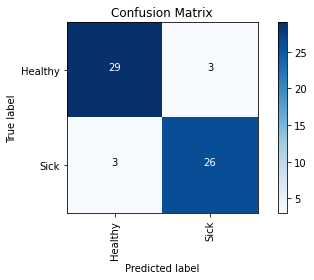

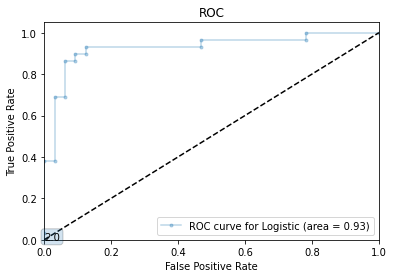

In [26]:
clf = LogisticRegression()
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

draw_confusion_matrix(y_test, y_pred, ['Healthy', 'Sick'])

make_roc("Logistic", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

[Provide explanation for each measure here] 

### Describe what an ROC curve is and what the results of this graph seem to be indicating

[Discuss] 

### Let's tweak a few settings. First let's set your solver to 'sag', your max_iter= 10, and set penalty = 'none' and rerun your model. Let's see how your results change!

Accuracy:  0.8852459016393442
Precision:  0.8928571428571429
Recall:  0.8620689655172413
F1 Score:  0.8771929824561403


/home/rob/Developer/ucla/cs188/.venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


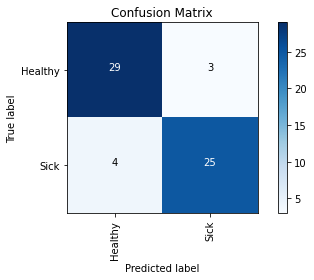

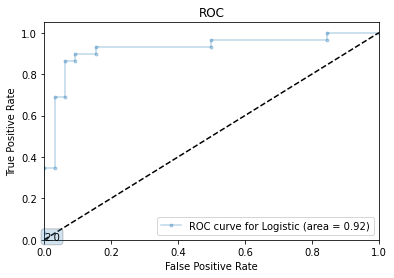

In [27]:
clf = LogisticRegression(solver='sag', max_iter=10, penalty='none')
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

draw_confusion_matrix(y_test, y_pred, ['Healthy', 'Sick'])

make_roc("Logistic", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

Accuracy:  0.8852459016393442
Precision:  0.8928571428571429
Recall:  0.8620689655172413
F1 Score:  0.8771929824561403


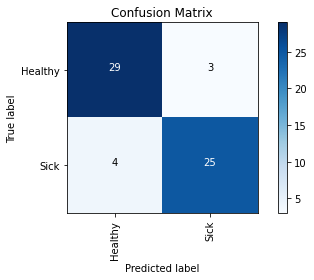

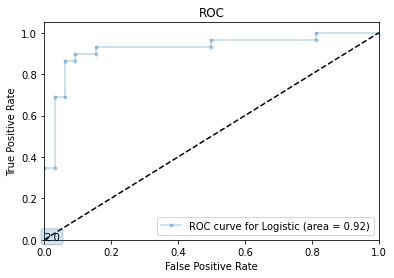

In [28]:
clf = LogisticRegression(solver='sag', max_iter=5000, penalty='none')
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

draw_confusion_matrix(y_test, y_pred, ['Healthy', 'Sick'])

make_roc("Logistic", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Explain what you changed, and why do you think, even though you 'fixed' the problem, that you may have harmed the outcome. What other Parameters you set may have impacted this result?

[Provide explanation here]

### Rerun your logistic classifier, but modify the penalty = 'l1', solver='liblinear' and again report the results.

Accuracy:  0.8852459016393442
Precision:  0.8928571428571429
Recall:  0.8620689655172413
F1 Score:  0.8771929824561403


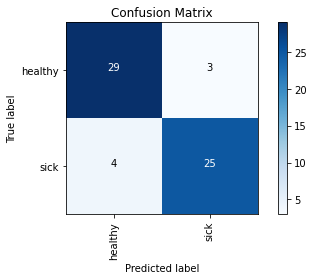

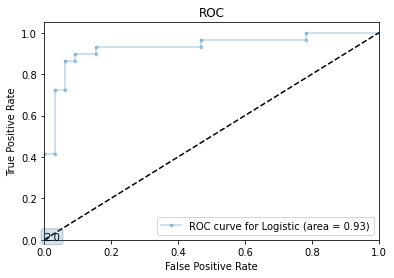

In [29]:
clf = LogisticRegression(solver='liblinear', max_iter=5000, penalty='l1')
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))


draw_confusion_matrix(y_test, y_pred, ['healthy', 'sick'])

make_roc("Logistic", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Explain what what the two solver approaches are, and why the liblinear likely produced the optimal outcome. 

[Provide explanation here]

### We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and how an L1 penalty works.

[Discuss prompt here]

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Implement a Support Vector Machine classifier on your pipelined data. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [30]:
clf = SVC(probability=True)
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Report the accuracy, precision, recall, F1 Score, and confusion matrix and ROC Curve of the resulting model.

Accuracy:  0.8852459016393442
Precision:  0.8928571428571429
Recall:  0.8620689655172413
F1 Score:  0.8771929824561403


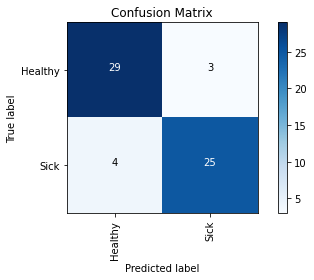

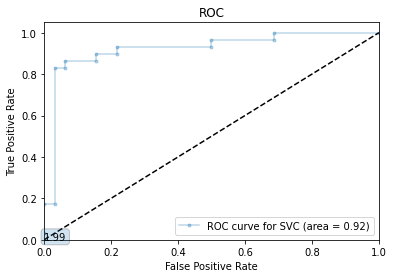

In [31]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

draw_confusion_matrix(y_test, y_pred, ['Healthy', 'Sick'])

make_roc("SVC", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

Accuracy:  0.8688524590163934
Precision:  0.8620689655172413
Recall:  0.8620689655172413
F1 Score:  0.8620689655172413


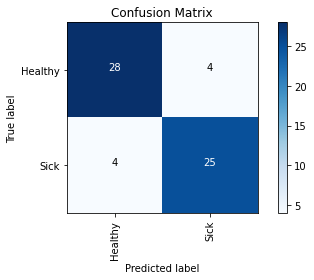

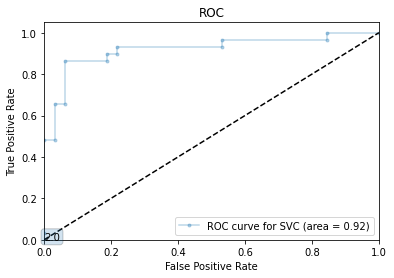

In [32]:
clf = SVC(probability=True, kernel='linear')
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

draw_confusion_matrix(y_test, y_pred, ['Healthy', 'Sick'])

make_roc("SVC", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

[Discuss Prompt here]

### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

[Provide Answer here:] 

## Baysian (Statistical) Classification

In class we learned about Naive Bayes, and statistical classification.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable Y  and dependent feature vector X1 through Xn. 

### Please implement a Naive Bayes Classifier on the pipelined data. For this model simply use the default parameters. Report out the number of mislabeled points that result, along with the accuracy, precision, recall, F1 Score and Confusion Matrix. Refer to documentation on implementing a NB Classifier [here](https://scikit-learn.org/stable/modules/naive_bayes.html)

Accuracy:  0.8524590163934426
Precision:  0.8125
Recall:  0.896551724137931
F1 Score:  0.8524590163934426


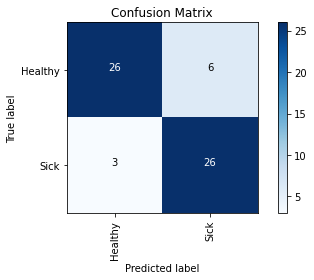

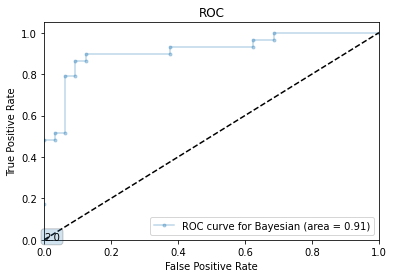

In [33]:
clf = GaussianNB()
_ = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

draw_confusion_matrix(y_test, y_pred, ['Healthy', 'Sick'])

make_roc("Bayesian", clf, y_test, X_test, ax=None, labe=20, proba=True, skip=1); 

### Discuss the observed results. What assumptions about our data are we making here and why might those be inacurate?

[Discuss here]

## Cross Validation and Model Selection

You've sampled a number of different classification techniques, leveraging clusters, linear classifiers, and Statistical Classifiers, as well as experimented with tweak different parameters to optimize perfiormance. Based on these experiments you should have settled on a particular model that performs most optimally on the chosen dataset. 

Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the Train-Test-Split. To ensure otherwise we will conduct a K-Fold Cross-Validation of our top two performing models, assess their cumulative performance across folds, and determine the best model for our particular data. 

## Select your top 2 performing models and run a K-Fold Cross Validation on both (use 10 folds). Report your best performing model.

In [34]:
kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
svm_acc, knn_acc, log_acc = [], [], []
svm_pre, knn_pre, log_pre = [], [], []
svm_rec, knn_rec, log_rec = [], [], []
svm_f1, knn_f1, log_f1 = [], [], []
y_pred_svm, y_pred_knn, y_pred_log = [], [], []

for train_index, test_index in kf.split(X_transformed, y):
    X_train, X_test = X_transformed[train_index], X_transformed[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = SVC().fit(X_train, y_train).predict(X_test)
    svm_acc.append(accuracy_score(y_test, y_pred))
    svm_pre.append(precision_score(y_test, y_pred))
    svm_rec.append(recall_score(y_test, y_pred))
    svm_f1.append(f1_score(y_test, y_pred))
    y_pred_svm.append(y_pred)
    
    
    y_pred = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train).predict(X_test)
    knn_acc.append(accuracy_score(y_test, y_pred))
    knn_pre.append(precision_score(y_test, y_pred))
    knn_rec.append(recall_score(y_test, y_pred))
    knn_f1.append(f1_score(y_test, y_pred))
    y_pred_knn.append(y_pred)
    
    y_pred = LogisticRegression(solver='liblinear', penalty='l2').fit(X_train, y_train).predict(X_test)
    log_acc.append(accuracy_score(y_test, y_pred))
    log_pre.append(precision_score(y_test, y_pred))
    log_rec.append(recall_score(y_test, y_pred))
    log_f1.append(f1_score(y_test, y_pred))
    y_pred_log.append(y_pred)

In [35]:
svm_acc_avg, svm_pre_avg, svm_rec_avg, svm_f1_avg = np.average(svm_acc), np.average(svm_pre), np.average(svm_rec), np.average(svm_f1)
knn_acc_avg, knn_pre_avg, knn_rec_avg, knn_f1_avg = np.average(knn_acc), np.average(knn_pre), np.average(knn_rec), np.average(knn_f1)
log_acc_avg, log_pre_avg, log_rec_avg, log_f1_avg = np.average(log_acc), np.average(log_pre), np.average(log_rec), np.average(log_f1)

In [36]:
print('SVM Averages - Accuracy: {:.3f} - Precission: {:.3f} - Recall: {:.3f} - F1: {:.3f}'.format(svm_acc_avg, svm_pre_avg, svm_rec_avg, svm_f1_avg))
print('KNN Averages - Accuracy: {:.3f} - Precission: {:.3f} - Recall: {:.3f} - F1: {:.3f}'.format(knn_acc_avg, knn_pre_avg, knn_rec_avg, knn_f1_avg))
print('LOG Averages - Accuracy: {:.3f} - Precission: {:.3f} - Recall: {:.3f} - F1: {:.3f}'.format(log_acc_avg, log_pre_avg, log_rec_avg, log_f1_avg))

SVM Averages - Accuracy: 0.874 - Precission: 0.899 - Recall: 0.819 - F1: 0.852
KNN Averages - Accuracy: 0.831 - Precission: 0.840 - Recall: 0.775 - F1: 0.803
LOG Averages - Accuracy: 0.861 - Precission: 0.886 - Recall: 0.803 - F1: 0.837


In [37]:
for i in range(10):
    print(f'SVM split {i+1} - Accuracy: {svm_acc[i]:.3f} - Precission: {svm_pre[i]:.3f} - Recall: {svm_rec[i]:.3f} - F1: {svm_f1[i]:.3f}')

SVM split 1 - Accuracy: 1.000 - Precission: 1.000 - Recall: 1.000 - F1: 1.000
SVM split 2 - Accuracy: 0.935 - Precission: 1.000 - Recall: 0.857 - F1: 0.923
SVM split 3 - Accuracy: 0.839 - Precission: 0.800 - Recall: 0.857 - F1: 0.828
SVM split 4 - Accuracy: 0.933 - Precission: 0.867 - Recall: 1.000 - F1: 0.929
SVM split 5 - Accuracy: 0.733 - Precission: 0.727 - Recall: 0.615 - F1: 0.667
SVM split 6 - Accuracy: 0.767 - Precission: 0.889 - Recall: 0.571 - F1: 0.696
SVM split 7 - Accuracy: 0.900 - Precission: 1.000 - Recall: 0.786 - F1: 0.880
SVM split 8 - Accuracy: 0.800 - Precission: 0.786 - Recall: 0.786 - F1: 0.786
SVM split 9 - Accuracy: 0.933 - Precission: 1.000 - Recall: 0.857 - F1: 0.923
SVM split 10 - Accuracy: 0.900 - Precission: 0.923 - Recall: 0.857 - F1: 0.889


In [38]:
for i in range(10):
    print(f'KNN split {i+1} - Accuracy: {knn_acc[i]:.3f} - Precission: {knn_pre[i]:.3f} - Recall: {knn_rec[i]:.3f} - F1: {knn_f1[i]:.3f}')

KNN split 1 - Accuracy: 0.968 - Precission: 0.933 - Recall: 1.000 - F1: 0.966
KNN split 2 - Accuracy: 0.903 - Precission: 0.923 - Recall: 0.857 - F1: 0.889
KNN split 3 - Accuracy: 0.903 - Precission: 0.867 - Recall: 0.929 - F1: 0.897
KNN split 4 - Accuracy: 0.833 - Precission: 0.786 - Recall: 0.846 - F1: 0.815
KNN split 5 - Accuracy: 0.733 - Precission: 0.727 - Recall: 0.615 - F1: 0.667
KNN split 6 - Accuracy: 0.700 - Precission: 0.727 - Recall: 0.571 - F1: 0.640
KNN split 7 - Accuracy: 0.900 - Precission: 1.000 - Recall: 0.786 - F1: 0.880
KNN split 8 - Accuracy: 0.767 - Precission: 0.769 - Recall: 0.714 - F1: 0.741
KNN split 9 - Accuracy: 0.833 - Precission: 0.846 - Recall: 0.786 - F1: 0.815
KNN split 10 - Accuracy: 0.767 - Precission: 0.818 - Recall: 0.643 - F1: 0.720


In [39]:
for i in range(10):
    print(f'LOG split {i+1} - Accuracy: {log_acc[i]:.3f} - Precission: {log_pre[i]:.3f} - Recall: {log_rec[i]:.3f} - F1: {log_f1[i]:.3f}')

LOG split 1 - Accuracy: 0.903 - Precission: 0.824 - Recall: 1.000 - F1: 0.903
LOG split 2 - Accuracy: 0.968 - Precission: 1.000 - Recall: 0.929 - F1: 0.963
LOG split 3 - Accuracy: 0.903 - Precission: 0.923 - Recall: 0.857 - F1: 0.889
LOG split 4 - Accuracy: 0.867 - Precission: 0.846 - Recall: 0.846 - F1: 0.846
LOG split 5 - Accuracy: 0.700 - Precission: 0.667 - Recall: 0.615 - F1: 0.640
LOG split 6 - Accuracy: 0.767 - Precission: 0.889 - Recall: 0.571 - F1: 0.696
LOG split 7 - Accuracy: 0.900 - Precission: 1.000 - Recall: 0.786 - F1: 0.880
LOG split 8 - Accuracy: 0.833 - Precission: 0.800 - Recall: 0.857 - F1: 0.828
LOG split 9 - Accuracy: 0.900 - Precission: 1.000 - Recall: 0.786 - F1: 0.880
LOG split 10 - Accuracy: 0.867 - Precission: 0.917 - Recall: 0.786 - F1: 0.846


[Discuss]